import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

!git clone https://github.com/SysCV/sam-hq.git
!pip install timm
os.chdir('sam-hq')
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor


In [2]:
!mkdir pretrained_checkpoint
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
!mv sam_hq_vit_l.pth pretrained_checkpoint


--2024-04-26 11:50:42--  https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
Resolving huggingface.co (huggingface.co)... 13.35.7.57, 13.35.7.81, 13.35.7.5, ...
Connecting to huggingface.co (huggingface.co)|13.35.7.57|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/4e/d94e04992ac4e3ea45fcc1c523974540cdbef274e295d4aaacc69b4f19ee63b7/e1a6c385d62bf005ded91a54d5ec55c985cfc4103ef89c08d90f39f04934c343?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sam_hq_vit_l.pth%3B+filename%3D%22sam_hq_vit_l.pth%22%3B&Expires=1714391442&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNDM5MTQ0Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kOS80ZS9kOTRlMDQ5OTJhYzRlM2VhNDVmY2MxYzUyMzk3NDU0MGNkYmVmMjc0ZTI5NWQ0YWFhY2M2OWI0ZjE5ZWU2M2I3L2UxYTZjMzg1ZDYyYmYwMDVkZWQ5MWE1NGQ1ZWM1NWM5ODVjZmM0MTAzZWY4OWMwOGQ5MGYzOWYwNDkzNGMzNDM%7EcmVzcG9uc2UtY29udGVud

In [3]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def show_res(masks, scores, input_point, input_label, input_box, image):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,5))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        if input_box is not None:
            box = input_box[i]
            show_box(box, plt.gca())
        if (input_point is not None) and (input_label is not None):
            show_points(input_point, input_label, plt.gca())

        print(f"Score: {score:.3f}")
        plt.title("Input Image and Predicted Mask")
        plt.axis('off')
        plt.show()


def show_res_multi(masks, scores, input_point, input_label, input_box, image):
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    for box in input_box:
        show_box(box, plt.gca())
    for score in scores:
        print(f"Score: {score:.3f}")
    plt.axis('off')
    plt.show()


In [4]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

<All keys matched successfully>


Examples of PA-SAM on hard to segment items

Score: 0.894


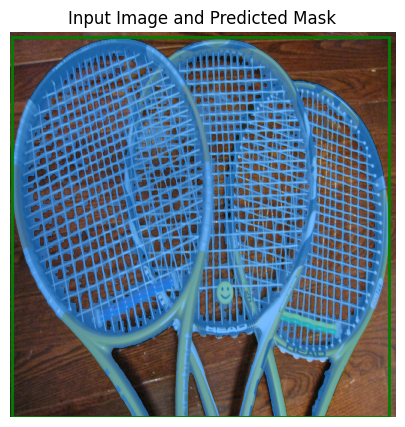

In [5]:
image = cv2.imread('demo/input_imgs/example0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([[4,13,1007,1023]])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Score: 0.920


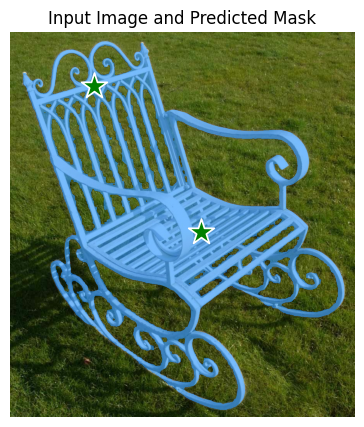

In [6]:
image = cv2.imread('demo/input_imgs/example2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_point = np.array([[495,518],[217,140]])
input_label = np.ones(input_point.shape[0])
input_box = None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= True,
)
show_res(masks,scores,input_point, input_label, input_box, image)

Setup the data

In [7]:
images_dir = "/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images"
images = []
for fname in os.listdir(images_dir):
    im = cv2.imread(os.path.join(images_dir, fname))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    imarray = np.array(im)
    images.append(imarray)

images = np.asarray(images) 

masks_dir = "/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths"
ground_truths = []
for fname in os.listdir(masks_dir):
    im = cv2.imread(os.path.join(masks_dir, fname))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    imarray = np.array(im)
    ground_truths.append(imarray)

ground_truths = np.asarray(ground_truths) 

In [8]:
def get_input(i):
    im=Image.open(os.path.join(masks_dir, os.listdir(masks_dir)[i]))
    immat = im.load()
    (X, Y) = im.size
    m = np.zeros((X, Y))

    for x in range(X):
        for y in range(Y):
            m[x, y] = immat[(x, y)] != (255, 255, 255)
    m = m / np.sum(np.sum(m))
    dx = np.sum(m, 1)
    dy = np.sum(m, 0)

    # expected values
    cx = np.sum(dx * np.arange(X))
    cy = np.sum(dy * np.arange(Y))
    input = np.array([[cx-50,cy],[cx+50,cy]])
    return(input)

In [19]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  #x_min = max(0, x_min - np.random.randint(0, 20))
  #x_max = min(W, x_max + np.random.randint(0, 20))
  #y_min = max(0, y_min - np.random.randint(0, 20))
  #y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [58]:
img = cv2.imread('/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/mask_covid_1018.png')

Example of using PA-SAM on an X-ray

Score: 0.774


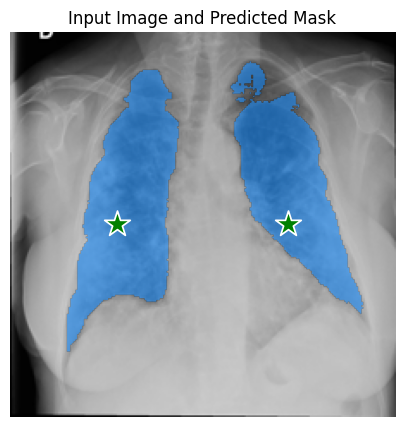

In [57]:
image = cv2.imread('/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/covid_1018.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#input_point = np.array([[61.5,111],[161.5,100]])
input_point = get_input(0)
input_label = np.ones(input_point.shape[0])
input_box = None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= True,
)
show_res(masks,scores,input_point, input_label, input_box, image)

In [11]:
masks.shape

(1, 224, 224)

In [59]:
img_copy = image.copy()
 
for rows_index in range(0, 224):
    for cols_index in range(0, 224):
            if masks[0][rows_index][cols_index]:
                img_copy[rows_index][cols_index] = np.array([255,255,255]) # white pixel
            else:
                img_copy[rows_index][cols_index] = np.array([0,0,0]) # black pixel


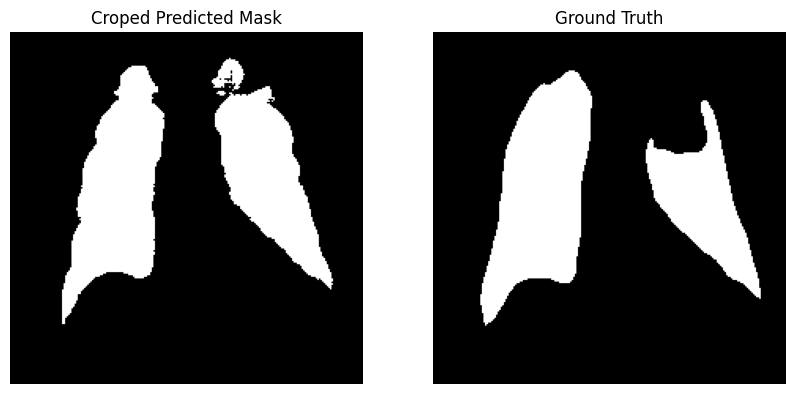

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_copy)
ax[0].set_title("Croped Predicted Mask")
ax[0].axis("off")
ax[1].imshow(img)
ax[1].set_title("Ground Truth")
ax[1].axis("off")

plt.show()

In [44]:
gt_mask = np.array(img)[:,:,0].astype(bool)
predicted_mask = np.array(img_copy).astype(bool)
# Calculate Intersection over Union (IoU)
intersection = np.logical_and(gt_mask, predicted_mask[:,:,0])
union = np.logical_or(gt_mask, predicted_mask[:,:,0])
iou = np.sum(intersection) / np.sum(union)
print(iou)

0.7774609471857178


***Inference***

In [ ]:
from tqdm import tqdm
iou_list = []
for i in tqdm(range(len(images))):    
    image = images[i]
    ground_truth = ground_truths[i]
    input_point = np.array([[61.5,111],[161.5,100]])
    input_label = np.ones(input_point.shape[0])
    input_box = None
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        box = input_box,
        multimask_output=False,
        hq_token_only= True,
    ) 
    for rows_index in range(0, 224):
        for cols_index in range(0, 224):
                if masks[0][rows_index][cols_index]:
                    image[rows_index][cols_index] = np.array([255,255,255]) # white pixel
                else:
                    image[rows_index][cols_index] = np.array([0,0,0]) # black pixel
    gt_mask = np.array(ground_truth)[:,:,0].astype(bool)
    predicted_mask = np.array(image).astype(bool)
    # Calculate Intersection over Union (IoU)
    intersection = np.logical_and(gt_mask, predicted_mask[:,:,0])
    union = np.logical_or(gt_mask, predicted_mask[:,:,0])
    iou = np.sum(intersection) / np.sum(union)

In [40]:
print(np.mean(iou))

0.7119269440088553
